> __Purpose:__ Implement an initial privacy attack to quantify how much re-identiifcation and linkability risk exists from personalization parameters (the decoder used in the co-adaptation algorithm). Thus, implement a basic ML model to link the decoder matrices back to the corresponding subject.  

-- 7 Subjects, therefore pure guessing would be 14.28% correct on average

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
import random
from kcs_ml_infr import *

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model

from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier

# Make annoying KNN warning go away since I'm not going to edit scikit learn's code lol
import warnings
warnings.filterwarnings("ignore")

random.seed(a=1)

# Load In Data

In [2]:
keys = ['METACPHS_S106', 'METACPHS_S107','METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112']

with open('Data\cphs_data_block1.pickle', 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    _, _, _, _, _, Ws_block1, _, _, _, _, _ = pickle.load(handle)

with open('Data\cphs_data_block2.pickle', 'rb') as handle:
    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
    _, _, _, _, _, Ws_block2, _, _, _, _, _ = pickle.load(handle)
    
update_ix = np.load(r"Data\update_ix.npy")
print(update_ix.shape)
print(update_ix)

(19,)
[    0  1200  2402  3604  4806  6008  7210  8412  9614 10816 12018 13220
 14422 15624 16826 18028 19230 20432 20769]


In [3]:
key_to_num = dict()
num_to_key = dict()
for idx, key in enumerate(keys):
    key_to_num[key] = idx
    num_to_key[idx] = key

# Params
# Set the number of k-folds
cv = 5
# Changed to 5 from 10 because the smallest class in cross val only has 7 instances
# NOTE: I also changed the default cv number in my function to be 5 because of this

my_metrics_cols=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds']
#my_models = [LogisticRegression(), KNeighborsClassifier(), GradientBoostingClassifier()]
my_models = [LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()]

In [4]:
num_conds = 8
dec_flattened_df1 = pd.DataFrame(columns=["Subject", "Condition", "Update Number", "Flattened Decoder"])
dec_flattened_df2 = pd.DataFrame(columns=["Subject", "Condition", "Update Number", "Flattened Decoder"])

for key in keys:
    participant_dec1 = Ws_block1[key]
    participant_dec2 = Ws_block2[key]
    
    for my_cond in range(num_conds):
        for update_number, update_idx in enumerate(update_ix):
            dec_flattened_df1.loc[len(dec_flattened_df1)] = [key, my_cond, update_number, np.ravel(participant_dec1[my_cond, update_idx, :, :])]
            dec_flattened_df2.loc[len(dec_flattened_df2)] = [key, my_cond, update_number, np.ravel(participant_dec2[my_cond, update_idx, :, :])]
        
dec_flattened_df = pd.concat((dec_flattened_df1, dec_flattened_df2))

print(dec_flattened_df.shape)
dec_flattened_df.head()

(2128, 4)


,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,METACPHS_S106,0,1,"[0.002722144351611262, 0.002605931562722017, 0..."
2,METACPHS_S106,0,2,"[-0.34157085409453486, 0.08410593293763585, -0..."
3,METACPHS_S106,0,3,"[-0.1738624752800762, 0.003705171262358347, 0...."
4,METACPHS_S106,0,4,"[0.8321061501817386, -1.3261242289666402, 0.28..."


In [5]:
# SPLIT BASED ON CONDITION NUMBERS
# initialization conditions
pos_init = [0, 1, 4, 5]
neg_init = [2, 3, 6, 7]

In [13]:
pos_dec_df = dec_flattened_df[dec_flattened_df["Condition"].isin(pos_init)]
neg_dec_df = dec_flattened_df[dec_flattened_df["Condition"].isin(neg_init)]

In [14]:
pos_dec_df.head()

,Subject,Condition,Update Number,Flattened Decoder
0,METACPHS_S106,0,0,"[0.002722144351611262, 0.002605931562722017, 0..."
1,METACPHS_S106,0,1,"[0.002722144351611262, 0.002605931562722017, 0..."
2,METACPHS_S106,0,2,"[-0.34157085409453486, 0.08410593293763585, -0..."
3,METACPHS_S106,0,3,"[-0.1738624752800762, 0.003705171262358347, 0...."
4,METACPHS_S106,0,4,"[0.8321061501817386, -1.3261242289666402, 0.28..."


In [24]:
pos_dec_expanded_df = pd.DataFrame()
for my_row in range(pos_dec_df.shape[0]):
    test=pd.DataFrame(pos_dec_df.iloc[my_row,3]).T
    pos_dec_expanded_df = pd.concat((pos_dec_expanded_df, test))

pos_dec_expanded_df.reset_index(inplace=True, drop=True)
pos_dec_expanded_df.insert(loc=0, column='Update Number', value=list(pos_dec_df['Update Number']))
pos_dec_expanded_df.insert(loc=0, column='Condition', value=list(pos_dec_df['Condition']))
pos_dec_expanded_df.insert(loc=0, column='Subject', value=list(pos_dec_df['Subject']))

##################################################################

neg_dec_expanded_df = pd.DataFrame()
for my_row in range(neg_dec_df.shape[0]):
    test=pd.DataFrame(neg_dec_df.iloc[my_row,3]).T
    neg_dec_expanded_df = pd.concat((neg_dec_expanded_df, test))

neg_dec_expanded_df.reset_index(inplace=True, drop=True)
neg_dec_expanded_df.insert(loc=0, column='Update Number', value=list(neg_dec_df['Update Number']))
neg_dec_expanded_df.insert(loc=0, column='Condition', value=list(neg_dec_df['Condition']))
neg_dec_expanded_df.insert(loc=0, column='Subject', value=list(neg_dec_df['Subject']))

print(neg_dec_expanded_df.shape)
neg_dec_expanded_df.head()

(1064, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
0,METACPHS_S106,2,0,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.00138,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
1,METACPHS_S106,2,1,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.00138,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528
2,METACPHS_S106,2,2,0.825933,-1.469018,0.571815,0.303863,0.205992,0.238584,-0.450090,...,-0.400606,-0.154473,-0.322371,0.164873,-0.67910,-1.089572,-0.768722,0.411089,0.144031,1.635522
3,METACPHS_S106,2,3,1.058931,0.375012,0.282296,-1.399287,0.370223,-1.239059,0.851994,...,-0.940544,0.391354,0.895968,-1.135626,0.06797,0.045250,0.558158,0.975949,0.186491,-0.837941
4,METACPHS_S106,2,4,1.374515,0.394081,-0.840234,0.015707,-0.004174,-0.127003,0.601826,...,0.124491,-0.618320,0.112218,-0.764695,-0.35952,-1.060206,-0.921179,0.138452,1.569515,-0.345853


# Concat All 19 Update Model Results
> Should I be trying to use the same model but predicting on different datasets too?

In [22]:
def make_all_update_models(flattened_input_df, my_metrics_columns=['Algorithm', 'One Off Acc', 'CV Acc', 'K Folds'], my_models_list=[LogisticRegression(), KNeighborsClassifier(), GaussianNB(), LinearSVC(), SGDClassifier(), DecisionTreeClassifier(), GradientBoostingClassifier()], make_df=True, full_test_df=pd.DataFrame()):

    if make_df:
        full_test_df = pd.DataFrame(columns=my_metrics_columns)

    for i in range(19):
        print(f"{i} of {19}")
        ith_df, ith_test_df = nth_decoder_model(flattened_input_df, i, my_models_list, test=True)

        full_test_df = pd.concat((full_test_df, ith_test_df))

    full_test_df.drop('K Folds', axis=1, inplace=True)
    full_test_df.drop('One Off Acc', axis=1, inplace=True)
    full_test_df.drop('CV Acc', axis=1, inplace=True)

    return full_test_df

In [19]:
full_pos_test_df = make_all_update_models(pos_dec_expanded_df)
full_pos_test_df.head(8)

0 of 19
1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19


,Algorithm,One Off Acc,CV Acc,Test Acc,N
0,LogisticRegression(),NaN,15.385,0.0,0
0,KNeighborsClassifier(),NaN,5.128,0.0,0
0,GaussianNB(),NaN,100.0,100.0,0
0,LinearSVC(),NaN,15.385,0.0,0
0,SGDClassifier(),NaN,12.821,11.765,0


In [25]:
full_neg_test_df = make_all_update_models(neg_dec_expanded_df)
full_neg_test_df.head(8)

0 of 19
1 of 19
2 of 19
3 of 19
4 of 19
5 of 19
6 of 19
7 of 19
8 of 19
9 of 19
10 of 19
11 of 19
12 of 19
13 of 19
14 of 19
15 of 19
16 of 19
17 of 19
18 of 19


,Algorithm,Test Acc,N
0,LogisticRegression(),0.0,0
0,KNeighborsClassifier(),0.0,0
0,GaussianNB(),100.0,0
0,LinearSVC(),5.882,0
0,SGDClassifier(),11.765,0
0,DecisionTreeClassifier(),94.118,0
0,GradientBoostingClassifier(),94.118,0
0,LogisticRegression(),0.0,1


## Plot Accuracy As a Func of N

In [26]:
pos_lr_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LogisticRegression()']
pos_knn_df = full_pos_test_df[full_pos_test_df['Algorithm']=='KNeighborsClassifier()']
pos_svc_df = full_pos_test_df[full_pos_test_df['Algorithm']=='LinearSVC()']
pos_dt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='DecisionTreeClassifier()']
pos_gbt_df = full_pos_test_df[full_pos_test_df['Algorithm']=='GradientBoostingClassifier()']

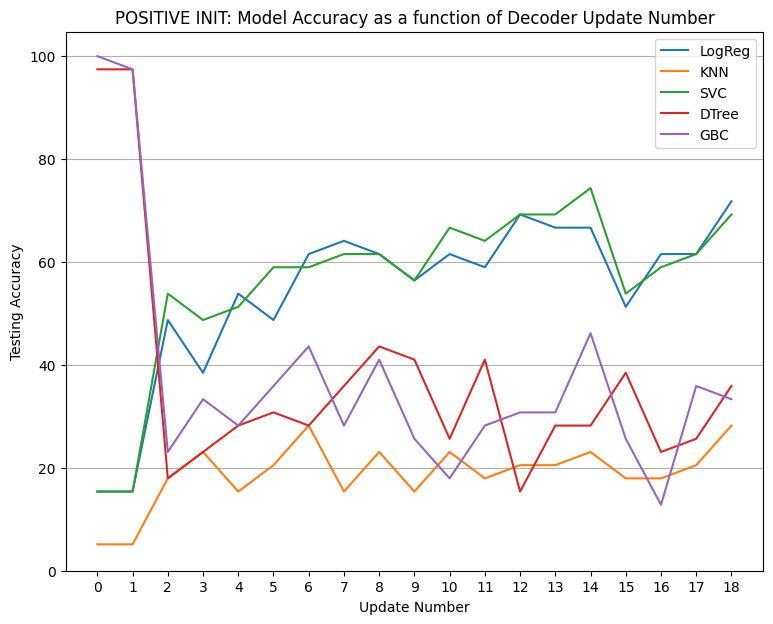

In [30]:
skip_block = 0
# SWITCH THIS TO 1 IF YOU RERUN THIS NB!!!
col_num = 2
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, pos_lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, pos_knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, pos_svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, pos_dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, pos_gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('POSITIVE INIT: Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

In [28]:
neg_lr_df = full_neg_test_df[full_neg_test_df['Algorithm']=='LogisticRegression()']
neg_knn_df = full_neg_test_df[full_neg_test_df['Algorithm']=='KNeighborsClassifier()']
neg_svc_df = full_neg_test_df[full_neg_test_df['Algorithm']=='LinearSVC()']
neg_dt_df = full_neg_test_df[full_neg_test_df['Algorithm']=='DecisionTreeClassifier()']
neg_gbt_df = full_neg_test_df[full_neg_test_df['Algorithm']=='GradientBoostingClassifier()']

In [31]:
neg_gbt_df.head()

,Algorithm,Test Acc,N
0,GradientBoostingClassifier(),94.118,0
0,GradientBoostingClassifier(),94.118,1
0,GradientBoostingClassifier(),5.882,2
0,GradientBoostingClassifier(),11.765,3
0,GradientBoostingClassifier(),47.059,4


Now plot for negative init case

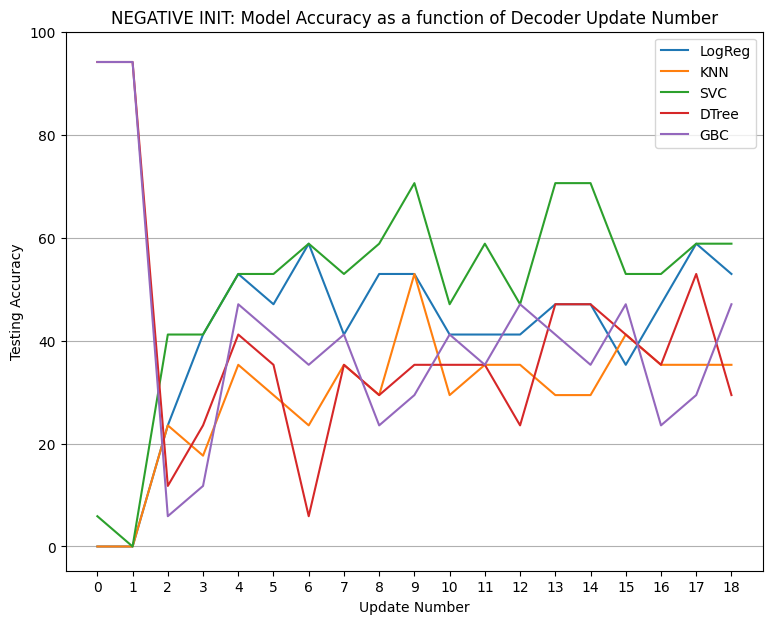

In [32]:
skip_block = 0
col_num = 1
my_x_updates = list(range(19))[skip_block:]

plt.figure(figsize=(9,7))
plt.plot(my_x_updates, neg_lr_df.iloc[skip_block:, col_num], label='LogReg')
plt.plot(my_x_updates, neg_knn_df.iloc[skip_block:, col_num], label='KNN')
plt.plot(my_x_updates, neg_svc_df.iloc[skip_block:, col_num], label='SVC')
plt.plot(my_x_updates, neg_dt_df.iloc[skip_block:, col_num], label='DTree')
plt.plot(my_x_updates, neg_gbt_df.iloc[skip_block:, col_num], label='GBC')
plt.xticks(np.arange(0, 19, 1.0))
plt.yticks(np.arange(0, 120, 20.0))
plt.grid(axis='y')
plt.xlabel('Update Number')
plt.ylabel('Testing Accuracy')
plt.title('NEGATIVE INIT: Model Accuracy as a function of Decoder Update Number')
plt.legend(loc='best')
plt.show()

Accuracies get considerably worse.  From the original (NB 104), we had the following:
- SVC: 80
- LR: 70
- KNN: 57
- GBC: 53
- DTree: 38

However, this is of course a caveat here: when we split the data into the pos and neg condition dfs, we therefore trained the models with half as much data as they otherwise wouldv'e had (as compared to NB 104 for instance which had the entire dataset to train on).  So let's rerun the NB 104 code using just a random 50% of the full data

In [39]:
# Shuffle the DF
full_dec_df = pd.concat((neg_dec_expanded_df, neg_dec_expanded_df))
shuffled_dec_df = full_dec_df.sample(frac=1)
print(shuffled_dec_df.shape)
shuffled_dec_df.head()

(2128, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
427,METACPHS_S111,6,9,-0.152218,0.571120,-0.058051,0.454639,0.224042,-0.156292,-0.460313,...,0.183002,-0.289371,-0.114780,-0.044248,0.010884,-0.186266,-0.366411,0.054780,0.311927,-0.704581
116,METACPHS_S107,6,2,0.266474,-0.003264,-0.005824,0.018466,0.000557,0.261710,-0.235936,...,0.140909,0.038047,-0.325279,0.014957,-0.014542,-0.054192,-0.000259,0.032463,0.065425,0.053170
344,METACPHS_S110,6,2,-0.207578,-0.033442,-0.005543,0.028609,0.027813,0.003471,0.088397,...,0.093561,-0.153008,-0.027709,-0.079675,-0.334258,0.125685,-0.043476,0.278158,-0.354870,-0.171396
83,METACPHS_S107,2,7,-0.002661,-0.315814,-0.333362,-0.546972,-0.462150,0.911080,-0.900352,...,-0.120137,-0.158666,-0.531729,0.044041,-0.125368,0.883050,-0.087263,-0.106347,-0.232495,-0.146321
217,METACPHS_S108,7,8,3.224938,-0.784739,-0.737948,-1.444326,-0.912968,0.874508,0.846639,...,0.732535,0.212593,0.461540,0.166344,0.113142,0.455816,-0.202876,0.184269,0.001372,-1.104350


In [40]:
half_df = shuffled_dec_df.iloc[shuffled_dec_df.shape[0]//2:, :]
print(half_df.shape)
half_df.head()

(1064, 131)


,Subject,Condition,Update Number,0,1,2,3,4,5,6,...,118,119,120,121,122,123,124,125,126,127
189,METACPHS_S108,3,18,0.636699,-1.085105,0.801000,-2.194879,-0.502344,-0.848613,0.929036,...,0.590312,0.333381,0.581755,-0.087256,1.043367,0.679465,-0.176926,-0.387010,1.128788,1.415617
511,METACPHS_S112,6,17,-0.238538,0.206741,-0.200108,-0.143826,0.038478,-0.102042,-0.286272,...,-0.200375,0.208743,0.217025,0.226692,0.090894,0.047361,0.492565,0.028660,-0.101242,-0.760568
507,METACPHS_S112,6,13,-0.115393,0.308557,0.074201,-0.427762,-0.158565,-0.046489,-0.421230,...,0.129834,-0.093125,0.313173,0.088006,-0.079101,-0.036150,-0.188251,0.006628,0.007993,-0.569723
586,METACPHS_S106,6,16,-0.467847,-0.057592,-0.060668,-0.210261,0.020480,-0.028515,0.085140,...,-0.359139,0.229168,-0.150308,-0.203151,-0.069031,0.194588,-0.149148,-0.006462,-0.190130,-0.036266
58,METACPHS_S106,7,1,-0.000533,-0.001358,-0.009211,-0.003424,-0.002861,-0.008239,-0.006398,...,-0.002812,-0.009092,-0.004493,-0.006459,-0.001380,-0.001834,-0.006104,-0.001417,-0.000446,-0.000528


In [42]:
half_df, half_test_df = nth_decoder_model(half_df, 18, my_models, test=True)
half_test_df.head(100)

,Algorithm,CV Acc,Test Acc,K Folds,N
0,LogisticRegression(),73.81,61.111,5,18
0,KNeighborsClassifier(),35.714,44.444,5,18
0,GaussianNB(),54.762,44.444,5,18
0,LinearSVC(),83.333,72.222,5,18
0,SGDClassifier(),73.81,50.0,5,18
0,DecisionTreeClassifier(),59.524,55.556,5,18
0,GradientBoostingClassifier(),66.667,55.556,5,18


In [43]:
half_test_df.iloc[:, 2]

0    61.111
0    44.444
0    44.444
0    72.222
0      50.0
0    55.556
0    55.556
Name: Test Acc, dtype: object

When comparing to the last values from either graph, notice that this performance is actually still better for all models, which was unexpected (especially for KNN!)